In [1]:
import json
import os
import mimetypes

import pandas as pd

from plot_from_dict import *

In [2]:
%cd ..
%pwd

c:\Users\wande\Travail\Ecole\ResearchSeminar\ML_research_seminar


c:\Users\wande\anaconda3\envs\gnn\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'c:\\Users\\wande\\Travail\\Ecole\\ResearchSeminar\\ML_research_seminar'

# I. Preparation of the data

In [3]:
list_dict = []

path_results = "./model/results/"

with os.scandir(path_results) as entries:

    for entry in entries:

        if entry.is_file() :

          name = entry.name

          if 'json' in mimetypes.guess_type(name)[0] :

            with open(f"{path_results}/{name}", 'r') as file:

              data = json.load(file)

            list_dict.append(data)

In [16]:
def to_table2(list_dict: List[Dict], per_dataset=False) -> pd.DataFrame:
    """
    Convert a list of dictionaries into a formatted Pandas DataFrame for tabular presentation.

    Parameters:
        list_dict (List[Dict]): A list of dictionaries containing the following keys:
            - 'dataset': The name of the dataset.
            - 'global_pooling_layer': The type of global pooling layer used.
            - 'local_pooling_layer': The type of local pooling layer used.
            - 'mean_accuracy': The mean accuracy value.
            - 'std_accuracy': The standard deviation of accuracy.

    Returns:
        pd.DataFrame: A formatted Pandas DataFrame with columns 'dataset', 'pooling_layer', and 'accuracy'.
            - 'dataset': Name of the dataset.
            - 'pooling_layer': Concatenation of 'local_pooling_layer' and 'global_pooling_layer'.
            - 'accuracy': Formatted string of mean accuracy ± standard deviation.

    Example Usage:
        list_dict = [
            {"dataset": "Dataset A", "global_pooling_layer": "Avg", "local_pooling_layer": "Max", "mean_accuracy": 0.85, "std_accuracy": 0.03},
            {"dataset": "Dataset B", "global_pooling_layer": "Sum", "local_pooling_layer": "Avg", "mean_accuracy": 0.92, "std_accuracy": 0.02}
        ]
        df = to_table(list_dict)
        print(df)

    """
    dic_results = {
        "dataset": [],
        "global_pooling_layer": [],
        "local_pooling_layer": [],
        "convolution_layer": [],
        "mean_accuracy": [],
        "std_accuracy": [],
        "training_time": [],
    }

    for dic in list_dict:
        dic_results["dataset"].append(dic["dataset"])
        dic_results["global_pooling_layer"].append(dic["global_pooling_layer"])
        dic_results["local_pooling_layer"].append(dic["local_pooling_layer"])
        dic_results["convolution_layer"].append(dic["convolution_layer"])
        dic_results["mean_accuracy"].append(dic["mean_accuracy"])
        dic_results["std_accuracy"].append(dic["std_accuracy"])
        training_time = 0
        for i in range(1, 11):
            try:
                training_time += (
                    dic["split " + str(i)]["train_time_per_epoch"]
                    * dic["split " + str(i)]["last_epoch"]
                )
            except KeyError:
                training_time += 0
        dic_results["training_time"].append(training_time / 10)

    df = pd.DataFrame(dic_results)

    df["local_pooling_layer"] = df["local_pooling_layer"].astype(str)
    indexes_to_bold = df.groupby("dataset")["mean_accuracy"].idxmax()
    df["accuracy"] = (
        "$"
        + df["mean_accuracy"].apply("{:.3f}".format).astype(str)
        + "\pm"
        + df["std_accuracy"].apply("{:.3f}".format).astype(str)
        + "$"
    )
    df.loc[indexes_to_bold, "accuracy"] = (
        "$\\bm{"
        + df.loc[indexes_to_bold, "mean_accuracy"].apply("{:.3f}".format).astype(str)
        + "\pm"
        + df.loc[indexes_to_bold, "std_accuracy"].apply("{:.3f}".format).astype(str)
        + "}$"
    )
    df = df.rename(
        columns={
            "convolution_layer": "Conv",
            "local_pooling_layer": "Local",
            "global_pooling_layer": "Global",
            "dataset": "Dataset",
        }
    )
    datasets = df["Dataset"].unique()
    df = df.pivot(
        index=["Conv", "Local", "Global"],
        columns="Dataset",
        values=["accuracy", "training_time", "mean_accuracy"],
    )


    df_ranking = df["mean_accuracy"].rank(ascending=False)#.groupby(["Conv", "Local"], group_keys=True)[datasets].mean()
    conv_map = df.reset_index(level=[0,1,2])["Conv"].to_dict()
    pool_map = df.reset_index(level=[0,1,2])["Local"].to_dict()
    average_ranking_df_archi = df_ranking.reset_index(level=[0]).groupby(["Conv"])[datasets].mean().astype(int)
    average_ranking_df_pooling = df_ranking.reset_index(level=[1]).groupby(["Local"])[datasets].mean().astype(int)

    if per_dataset:
        aggregator = lambda x:x
        aggregated_columns = datasets
    else:
        aggregator = lambda x:x.mean(axis=1)
        aggregated_columns = 0
        
    df_best_pooling = aggregator(df_ranking).reset_index(level=[0,1,2]).groupby(["Conv"]).idxmin()[aggregated_columns].copy()
    df_best_architecture = aggregator(df_ranking).reset_index(level=[0,1,2]).groupby(["Local"]).idxmin()[aggregated_columns].copy()
    best_indexes_by_architecture = list(set(df_best_pooling.values.flatten()))
    best_indexes_by_pooling = list(set(df_best_architecture.values.flatten()))
    df_best_pooling =  df_best_pooling.map(lambda x:pool_map[x])
    df_best_architecture =  df_best_architecture.map(lambda x:conv_map[x])

    df_worst_pooling = aggregator(df_ranking).reset_index(level=[0,1,2]).groupby(["Conv"]).idxmax()[aggregated_columns].copy()
    df_worst_architecture = aggregator(df_ranking).reset_index(level=[0,1,2]).groupby(["Local"]).idxmax()[aggregated_columns].copy()
    df_worst_pooling =  df_worst_pooling.map(lambda x:pool_map[x])
    df_worst_architecture =  df_worst_architecture.map(lambda x:conv_map[x])

    training_time = df["training_time"].sum(axis=1).copy().astype(int).astype(str)
    df = df.drop(columns=["training_time", "mean_accuracy"])
    df.columns = df.columns.droplevel(0)
    df = df.rename_axis(None, axis=1)
    df["Training Time"] = training_time

    df_by_architecture = df.iloc[best_indexes_by_architecture].copy()
    df_by_pooling = df.iloc[best_indexes_by_pooling].copy()
    
    return df, df_best_architecture, df_worst_architecture, average_ranking_df_archi, df_by_architecture, df_best_pooling, df_worst_pooling, average_ranking_df_pooling, df_by_pooling.reorder_levels([1,2,0])

In [4]:
path_homophily = "./homophily/homophily_data.csv"

df_homophily = pd.read_csv(path_homophily)
df_homophily['Name_Dataset'] = df_homophily['Name_Dataset'].apply(lambda s : s.upper())
df_homophily.head()

,Name_Dataset,Size_dataset,Nb_class,Nb_features,Seed,Homophily_edge_train,Homophily_edge_test,Homophily_node_train,Homophily_node_test,Homophily_edge_insensitive_train,Homophily_edge_insensitive_test
0,MUTAG,188,2,7,12345,0.721,0.722,0.661,0.662,0.034,0.035
1,ENZYMES,600,6,3,12345,0.667,0.660,0.665,0.664,0.370,0.399
2,PROTEINS,1113,2,3,12345,0.657,0.654,0.652,0.648,0.372,0.367
3,PATTERN,10000,2,3,12345,0.333,0.333,0.333,0.333,0.000,0.000
4,CLUSTER,10000,6,7,12345,0.905,0.905,0.901,0.901,0.009,0.000


In [5]:
for dic in list_dict :
  name_dataset = dic["dataset"]
  dic["homophily"] = df_homophily.loc[df_homophily['Name_Dataset'] == name_dataset, 'Homophily_edge_train'].values[0]

In [6]:
# creating a variable of pooling that takes into account the global and the local pooling\n",
for dic in list_dict:
    dic["pooling"] = f"{dic['global_pooling_layer']}+{dic['local_pooling_layer']}"

In [7]:
# creating a variable that takes into account the pooling and the architecture",
for dic in list_dict:
    dic["pooling_and_archi"] = f"{dic['pooling']}+{dic['convolution_layer']}"

# II. Scatter plot in 3D

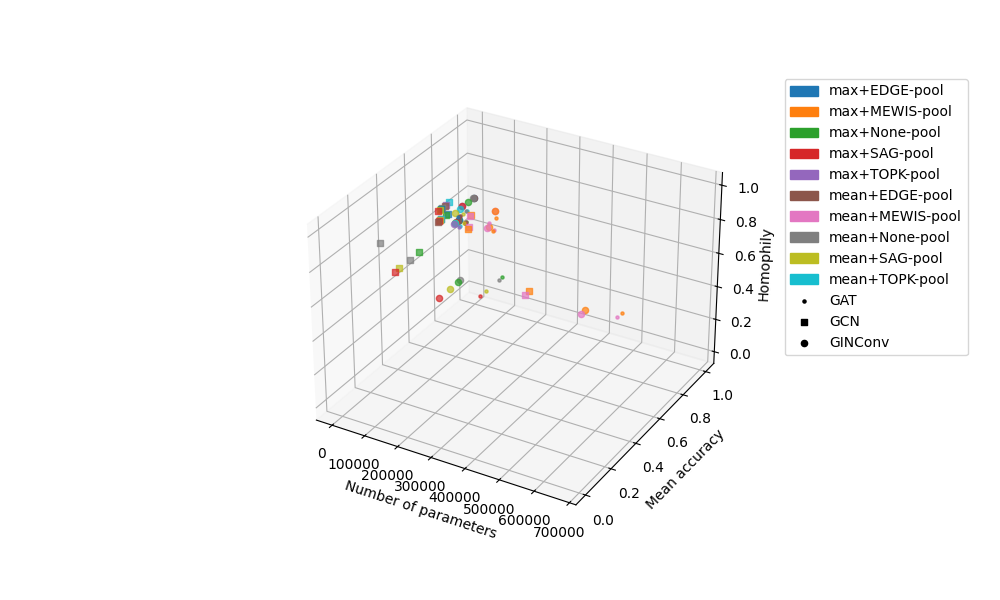

In [8]:
%matplotlib widget
plot_from_dict(list_dict, alpha=.7);

# III. Pairplot

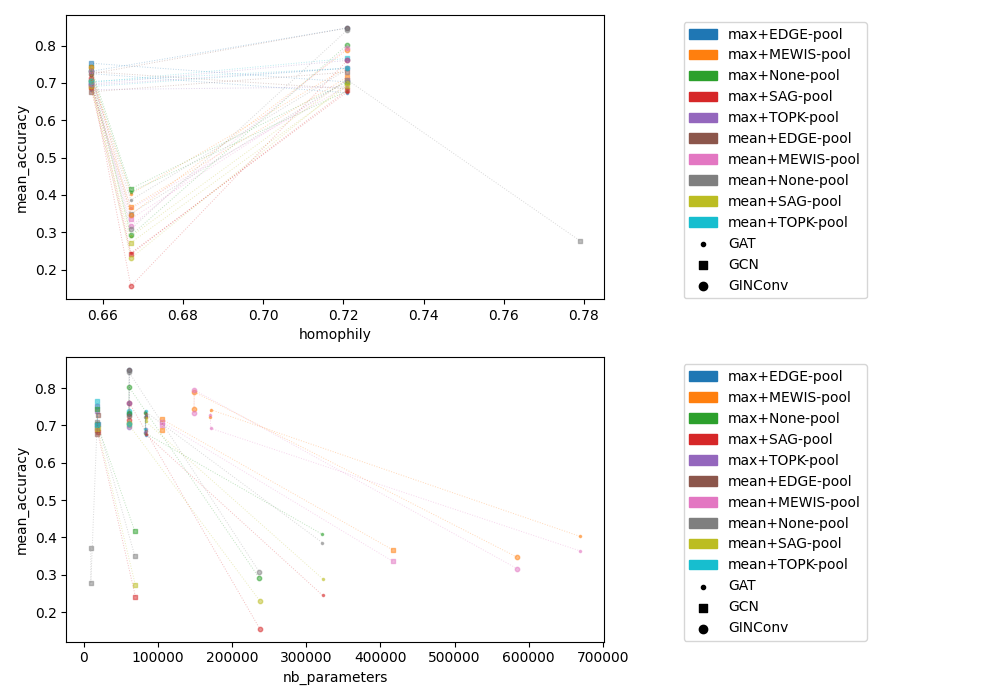

In [9]:
pairplot_from_dict(list_dict,
                   [('homophily','mean_accuracy'),('nb_parameters','mean_accuracy')],
                   dim_grid_subplots=(2,1),
                   figsize=(10,7),
                   plot=True,
                   kwargs1={'alpha' : .5, 's' : 10.},
                   kwargs2={'bbox_to_anchor' : (1.5,1)},
                   kwargs3={'alpha' : .3, 'linestyle' : ':', 'linewidth' : .7},
                   )

# IV. Barplot

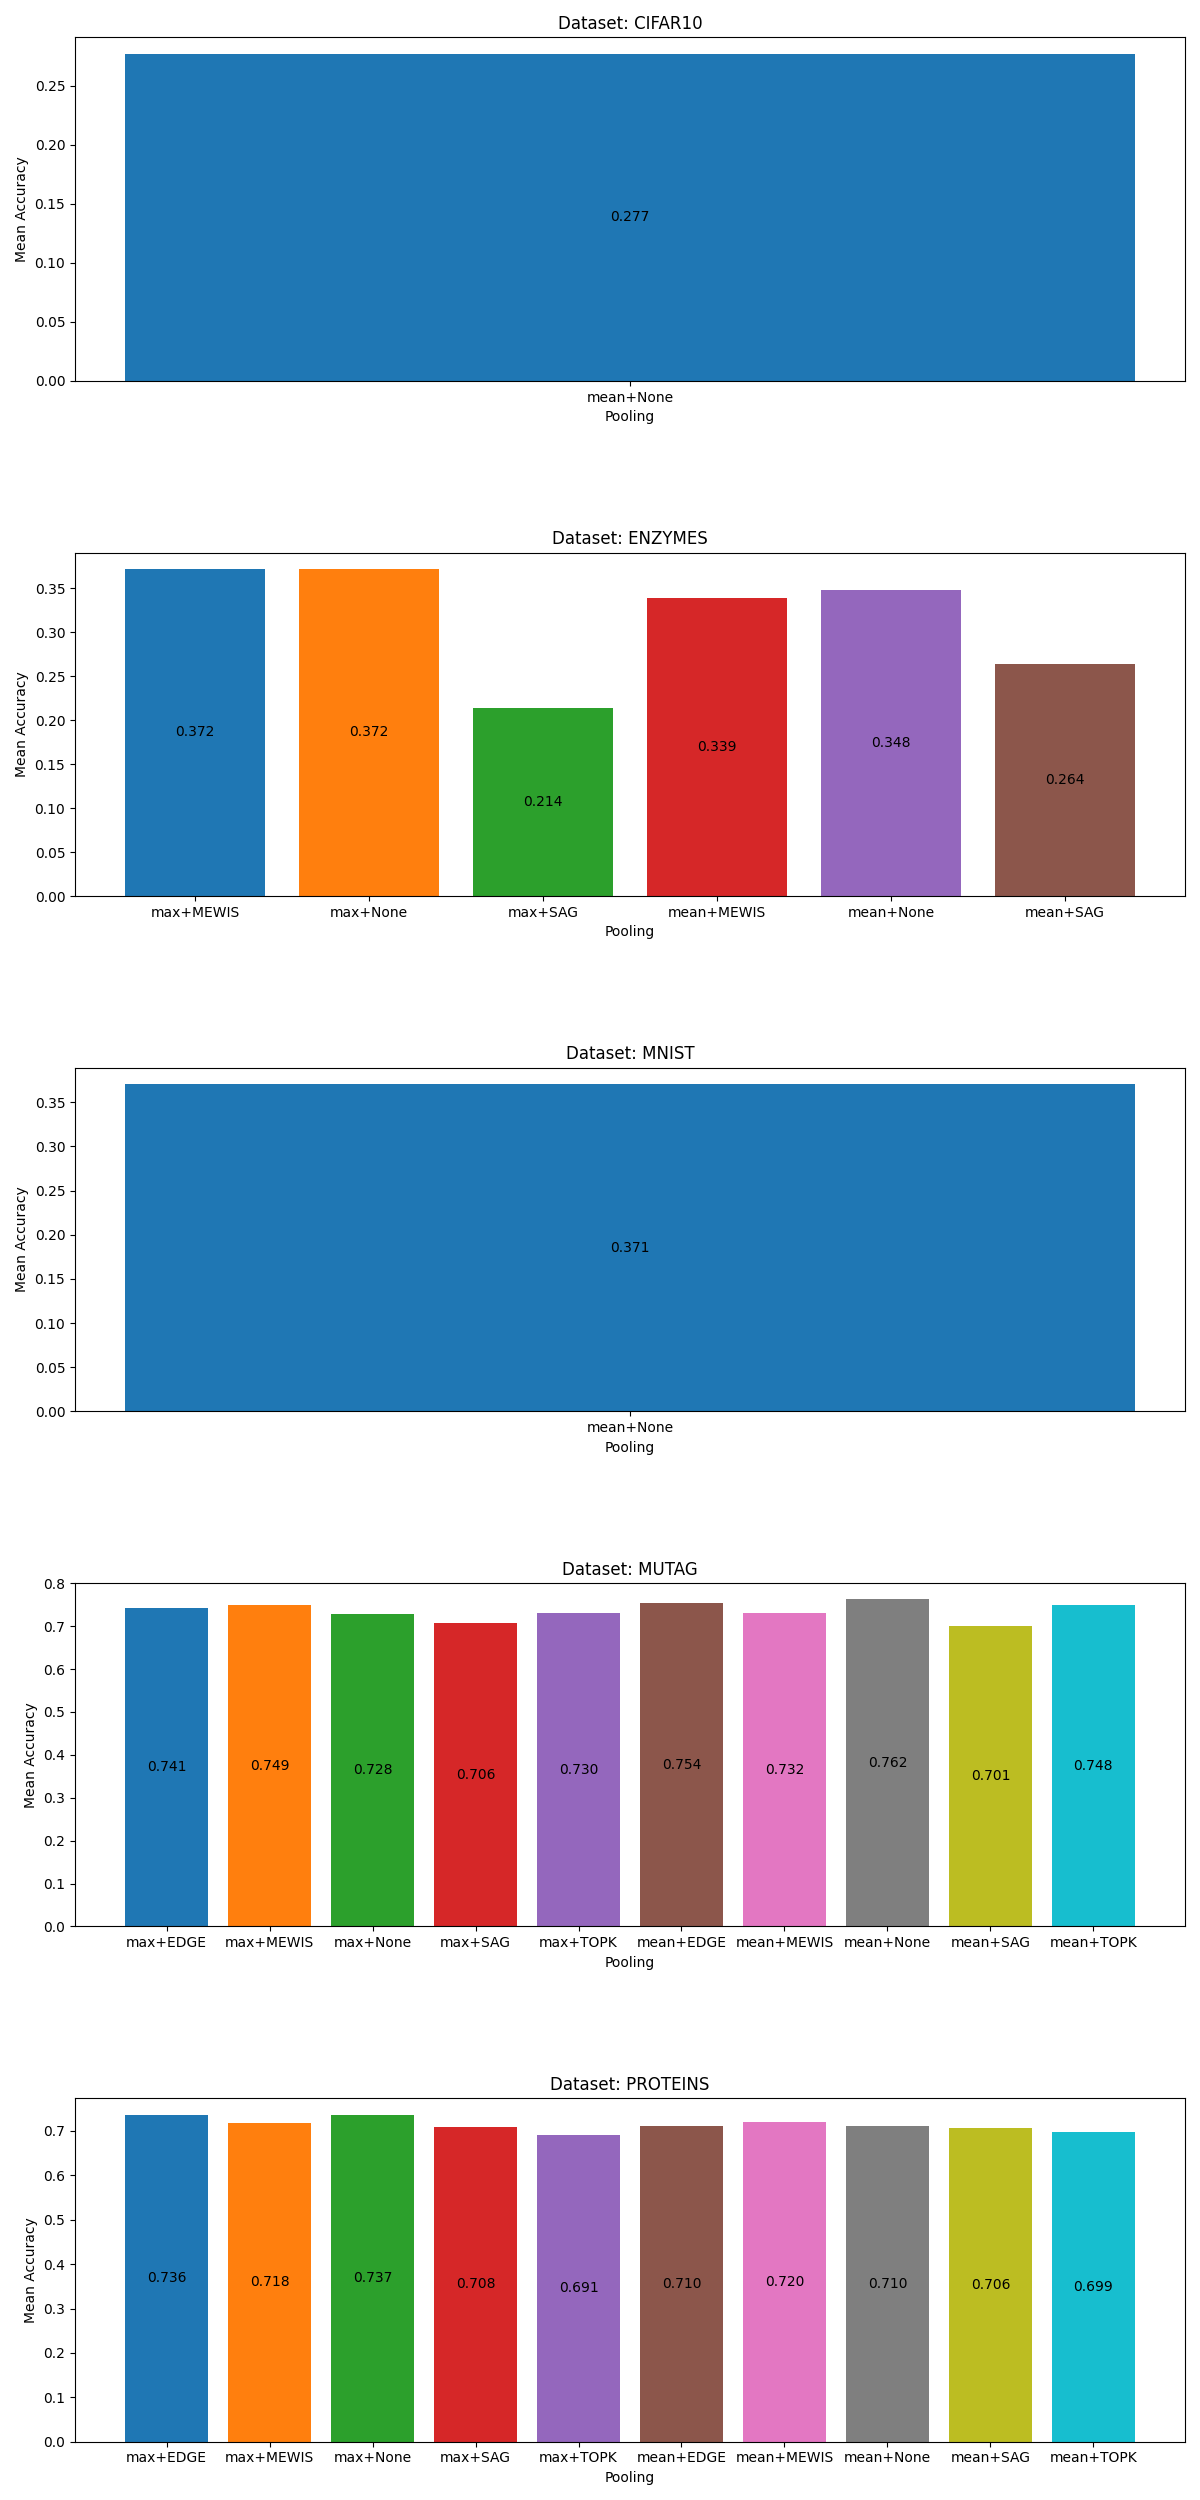

In [10]:
plot_bar_dataset(list_dict, groupby="pooling", stack=None, bar_width=0.12, x_figsize=12);

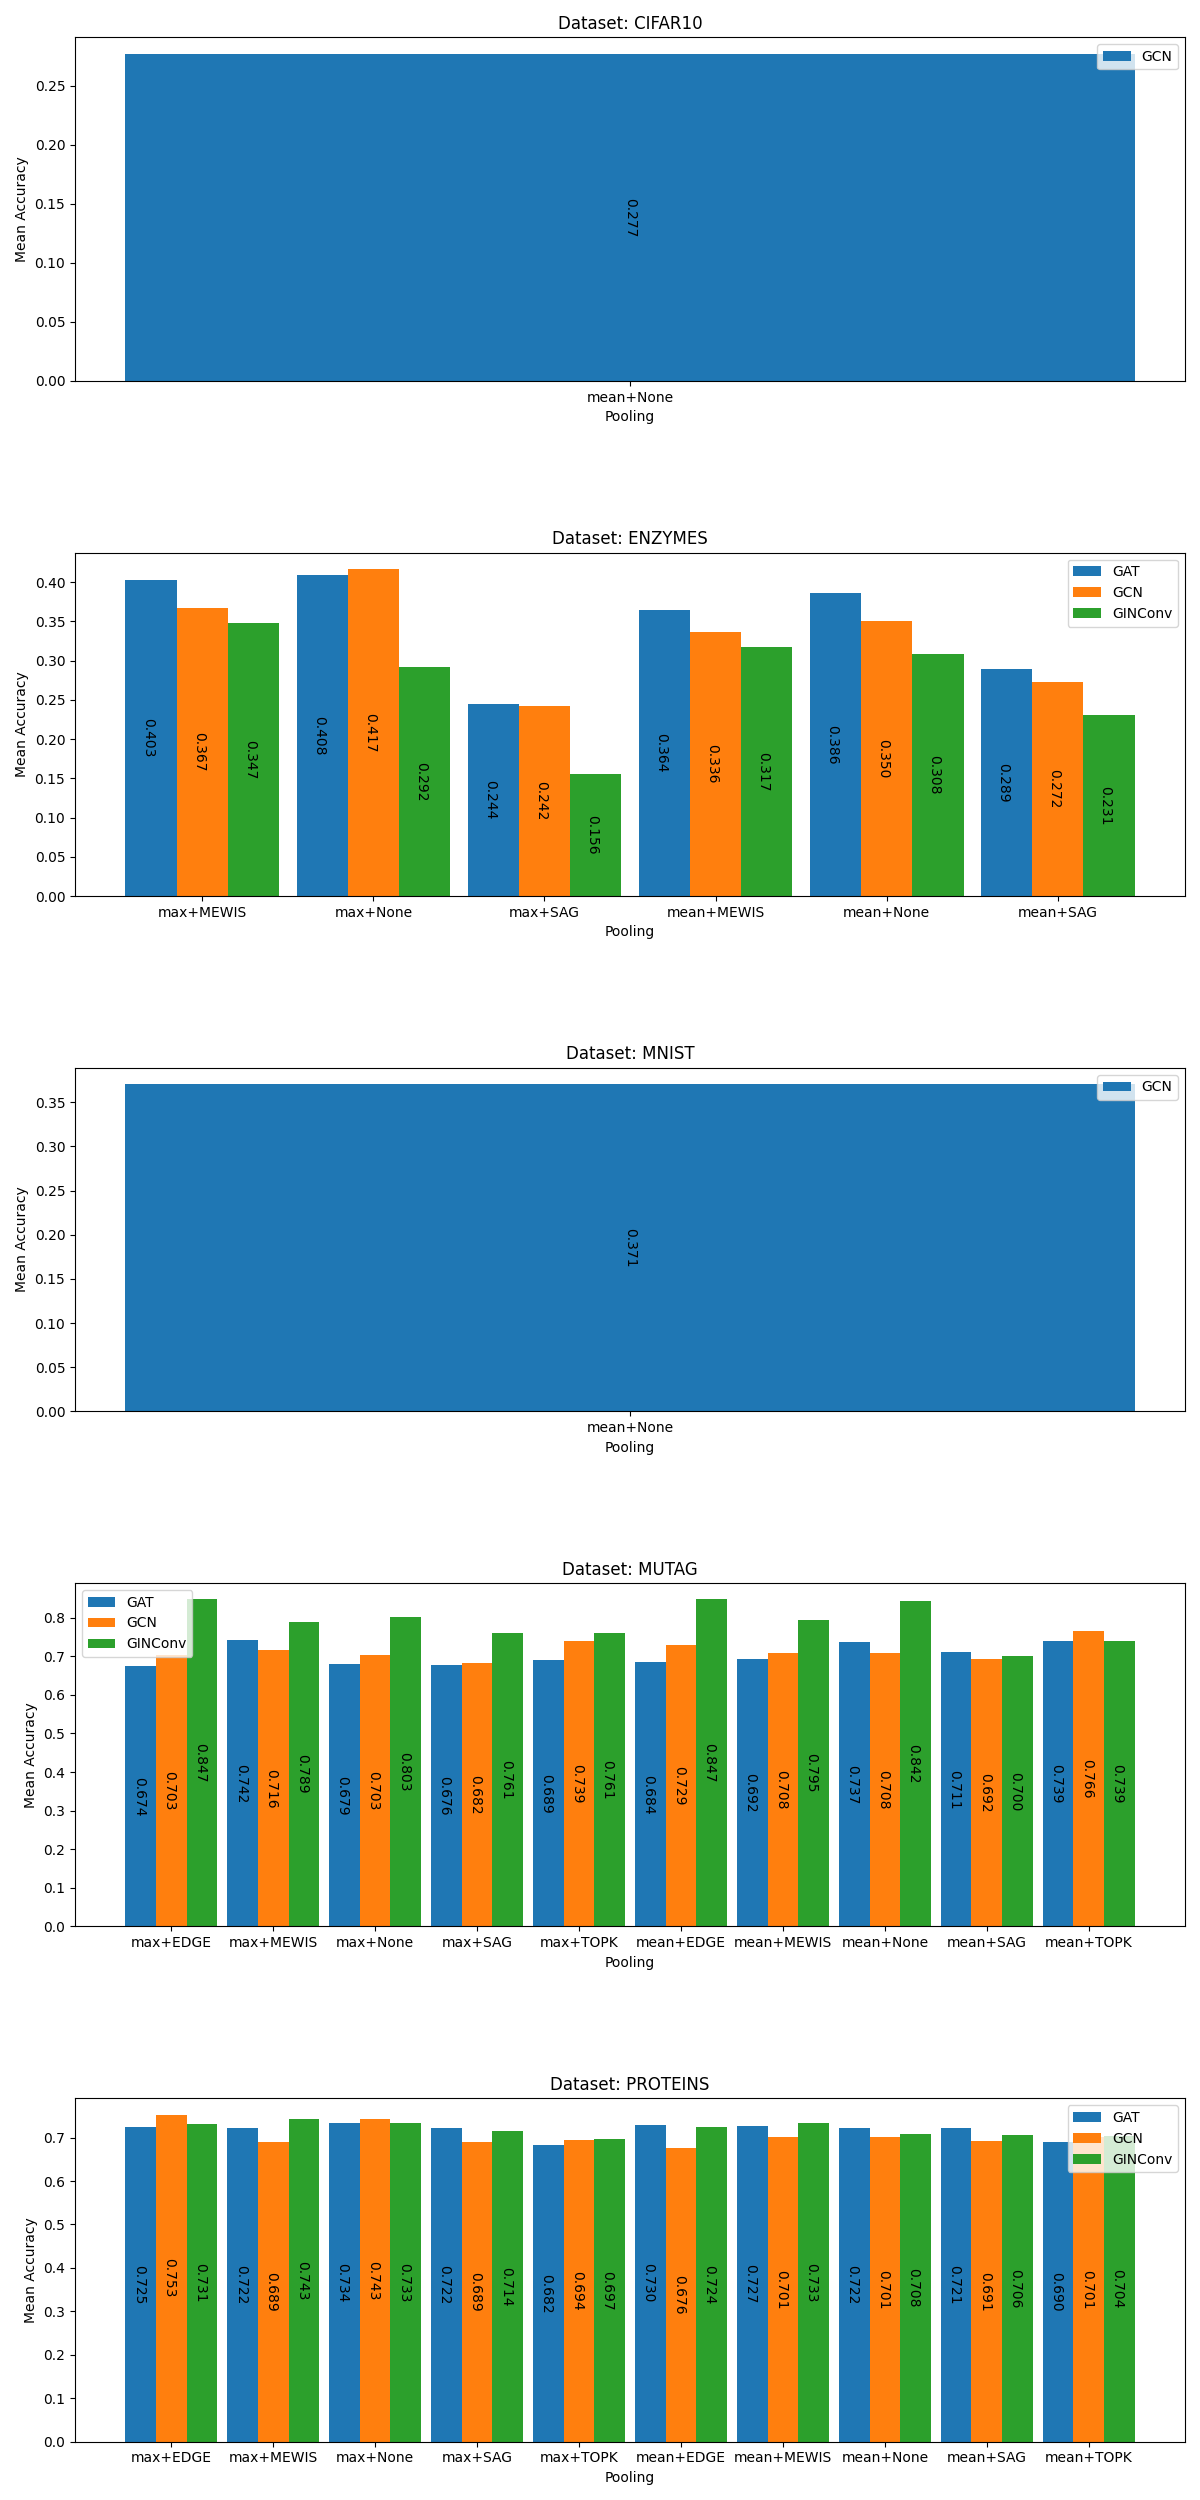

In [11]:
plot_bar_dataset(list_dict, groupby="pooling", stack="convolution_layer", bar_width=0.3, offset = .02, x_figsize=12);

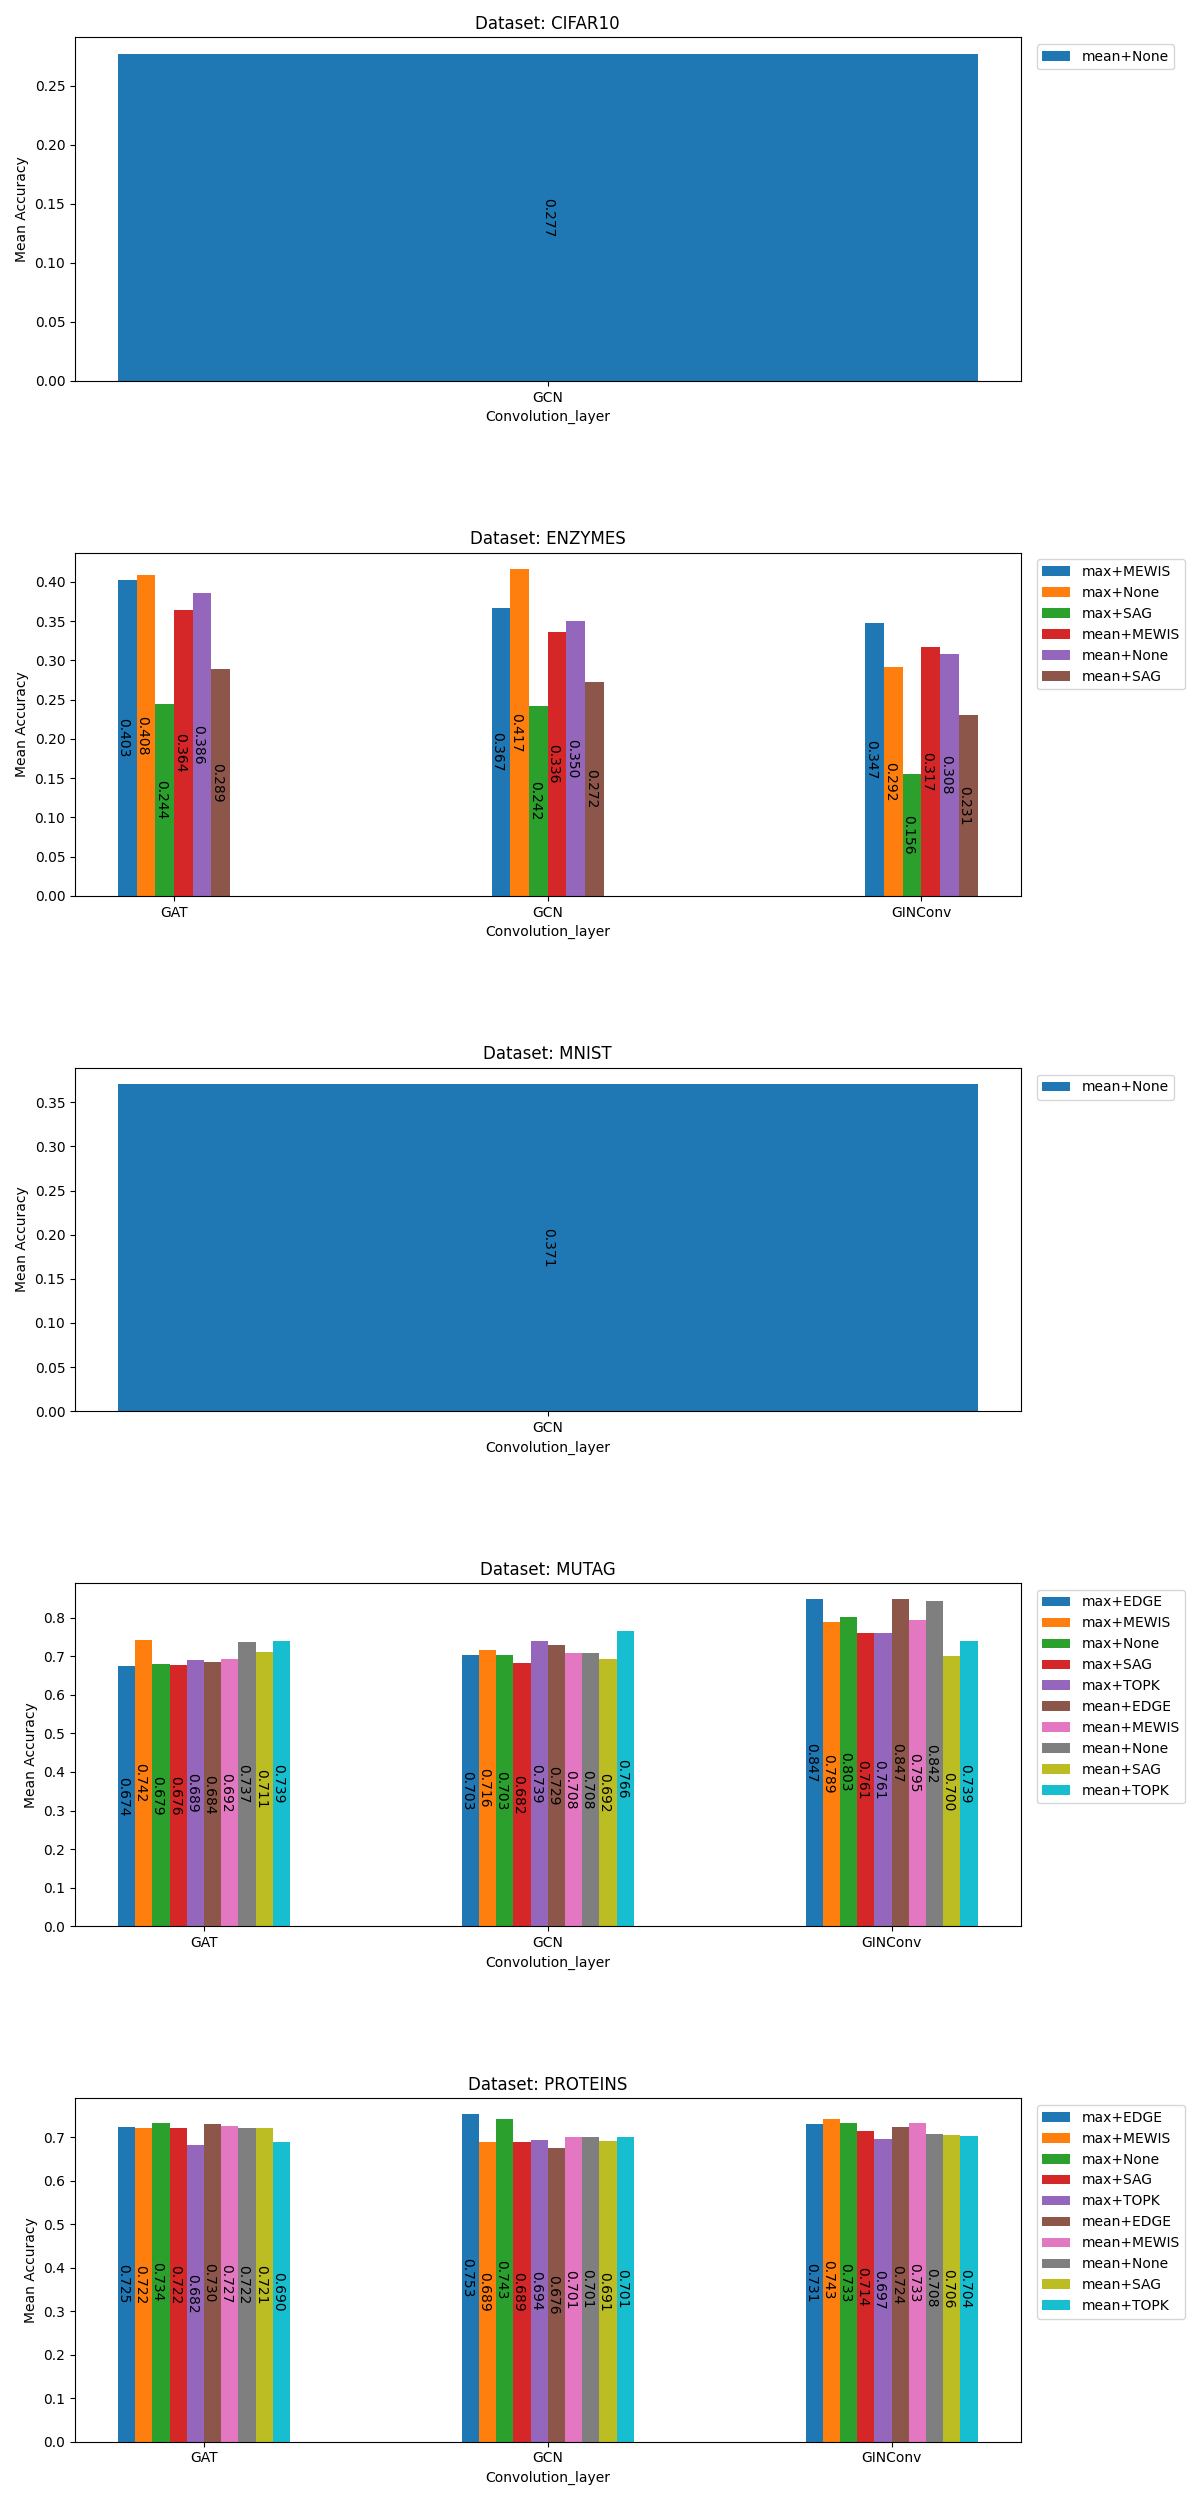

In [17]:
plot_bar_dataset(list_dict, groupby="convolution_layer", stack="pooling", bar_width=0.05, offset=0.01, x_figsize=12, kwargs2={'bbox_to_anchor' : (1.01,1)});

# V Losses

In [13]:
plot_losses(list_dict, "train")

In [14]:
plot_losses(list_dict, "val")

In [15]:
plot_acc_and_loss(list_dict, "train")

In [16]:
plot_acc_and_loss(list_dict, "val")

In [17]:
plot_acc_parameters(list_dict)

In [18]:
plot_acc_time_epoch(list_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [19]:
plot_acc_full_train_time(list_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# VI TABLE 

In [4]:
df, df_best_architecture, df_worst_architecture, average_ranking_df_archi, df_by_architecture, df_best_pooling, df_worst_pooling, average_ranking_df_pooling, df_by_pooling = to_table(list_dict, per_dataset=True)

In [5]:
average_ranking_df_pooling

Dataset,ENZYMES,MUTAG,PROTEINS
Local,,,
EDGE,7,15,11
MEWIS,12,13,13
None,8,14,10
SAG,25,21,19
TOPK,23,12,23


In [6]:
average_ranking_df_archi

Dataset,ENZYMES,MUTAG,PROTEINS
Conv,,,
GAT,16,21,14
GCN,17,17,20
GINConv,12,7,12


In [7]:
df_best_architecture

Dataset,ENZYMES,MUTAG,PROTEINS
Local,,,
EDGE,GINConv,GINConv,GCN
MEWIS,GINConv,GINConv,GINConv
None,GINConv,GINConv,GCN
SAG,GAT,GINConv,GAT
TOPK,GINConv,GCN,GINConv


In [8]:
df_worst_architecture

Dataset,ENZYMES,MUTAG,PROTEINS
Local,,,
EDGE,GAT,GAT,GCN
MEWIS,GCN,GAT,GCN
None,GAT,GAT,GCN
SAG,GINConv,GAT,GCN
TOPK,GCN,GAT,GAT


In [9]:
df_best_pooling

Dataset,ENZYMES,MUTAG,PROTEINS
Conv,,,
GAT,None,MEWIS,None
GCN,EDGE,TOPK,EDGE
GINConv,EDGE,EDGE,MEWIS


In [10]:
df_worst_pooling

Dataset,ENZYMES,MUTAG,PROTEINS
Conv,,,
GAT,SAG,EDGE,TOPK
GCN,TOPK,SAG,EDGE
GINConv,SAG,SAG,TOPK


In [11]:
df_by_architecture

ENZYMES                 MUTAG  \
Conv    Local Global                                               
GAT     MEWIS max          $0.295\pm0.040$       $0.742\pm0.086$   
        None  max          $0.310\pm0.053$       $0.679\pm0.087$   
GCN     EDGE  max          $0.294\pm0.026$       $0.703\pm0.081$   
              mean         $0.317\pm0.052$       $0.729\pm0.065$   
        TOPK  mean         $0.227\pm0.023$       $0.766\pm0.078$   
GINConv EDGE  max          $0.353\pm0.039$  $\bm{0.847\pm0.063}$   
              mean    $\bm{0.379\pm0.047}$       $0.847\pm0.070$   
        MEWIS max          $0.309\pm0.055$       $0.789\pm0.077$   

                                  PROTEINS Training Time  
Conv    Local Global                                      
GAT     MEWIS max          $0.722\pm0.022$          1783  
        None  max          $0.734\pm0.027$            59  
GCN     EDGE  max     $\bm{0.753\pm0.024}$           722  
              mean         $0.676\pm0.016$           793  
        TOPK  mean         $0.701\pm0.034$            33  
GINConv EDGE  max          $0.731\pm0.017$           694  
              mean         $0.724\pm0.016$           775  
        MEWIS max          $0.743\pm0.016$          1804

In [12]:
df_by_pooling.sort_index()

ENZYMES                 MUTAG  \
Local Global Conv                                                  
EDGE  max    GCN           $0.294\pm0.026$       $0.703\pm0.081$   
             GINConv       $0.353\pm0.039$  $\bm{0.847\pm0.063}$   
      mean   GINConv  $\bm{0.379\pm0.047}$       $0.847\pm0.070$   
MEWIS max    GINConv       $0.309\pm0.055$       $0.789\pm0.077$   
      mean   GINConv       $0.282\pm0.040$       $0.795\pm0.067$   
None  max    GCN           $0.316\pm0.044$       $0.703\pm0.065$   
      mean   GINConv       $0.337\pm0.047$       $0.842\pm0.073$   
SAG   max    GAT           $0.189\pm0.025$       $0.676\pm0.062$   
             GINConv       $0.188\pm0.040$       $0.761\pm0.081$   
      mean   GAT           $0.231\pm0.037$       $0.711\pm0.117$   
TOPK  mean   GCN           $0.227\pm0.023$       $0.766\pm0.078$   
             GINConv       $0.244\pm0.065$       $0.739\pm0.067$   

                                  PROTEINS Training Time  
Local Global Conv                                         
EDGE  max    GCN      $\bm{0.753\pm0.024}$           722  
             GINConv       $0.731\pm0.017$           694  
      mean   GINConv       $0.724\pm0.016$           775  
MEWIS max    GINConv       $0.743\pm0.016$          1804  
      mean   GINConv       $0.733\pm0.020$          1605  
None  max    GCN           $0.743\pm0.029$            29  
      mean   GINConv       $0.708\pm0.020$            31  
SAG   max    GAT           $0.722\pm0.050$            64  
             GINConv       $0.714\pm0.039$            35  
      mean   GAT           $0.721\pm0.022$            71  
TOPK  mean   GCN           $0.701\pm0.034$            33  
             GINConv       $0.704\pm0.038$            37

In [16]:
path_table = "Visualisation/results/tables"
os.makedirs(path_table, exist_ok=True)
list_of_dataframes = to_table(list_dict, per_dataset=True)
df, df_best_architecture, df_worst_architecture, average_ranking_df_archi, df_by_architecture, df_best_pooling, df_worst_pooling, average_ranking_df_pooling, df_by_pooling = list_of_dataframes

with open(os.path.join(path_table, 'full_result.txt'), 'w') as file:
    file.write(df.to_latex(multirow=True,index_names=False))

with open(os.path.join(path_table, 'average_ranking_archi.txt'), 'w') as file:
    file.write(average_ranking_df_archi.to_latex(multirow=True,index_names=False))

with open(os.path.join(path_table, 'average_ranking_pooling.txt'), 'w') as file:
    file.write(average_ranking_df_pooling.to_latex(multirow=True,index_names=False))

with open(os.path.join(path_table, 'result_by_archi.txt'), 'w') as file:
    file.write(df_by_architecture.to_latex(multirow=True,index_names=False))

with open(os.path.join(path_table, 'result_by_pooling.txt'), 'w') as file:
    file.write(df_by_pooling.to_latex(multirow=True,index_names=False))

list_of_dataframes = to_table(list_dict, per_dataset=False)
df, df_best_architecture, df_worst_architecture, average_ranking_df_archi, df_by_architecture, df_best_pooling, df_worst_pooling, average_ranking_df_pooling, df_by_pooling = list_of_dataframes

